<a href="https://colab.research.google.com/github/NightWalker888/ai_painting_journey/blob/main/train_diffusion_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# 检查GPU环境
!nvidia-smi

Wed Aug  9 15:53:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    29W /  70W |   9607MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
# 安装依赖python包
!pip install denoising_diffusion_pytorch -qq
!pip install datasets -qq

## 认识基础模块

In [12]:
# 创建UNet和扩散模型

from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import torch

model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8)
).cuda()

diffusion = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000   # number of steps
).cuda()

In [13]:
# 使用随机初始化的图片进行一次训练
training_images = torch.randn(8, 3, 128, 128)
loss = diffusion(training_images.cuda())
loss.backward()

In [14]:
# 采样1000步生成一张图片
sampled_images = diffusion.sample(batch_size = 4)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

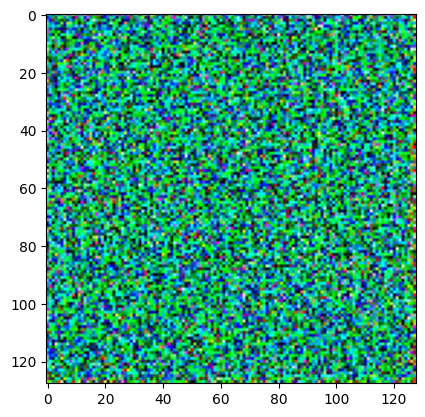

In [30]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms as transforms


# 如果张量在 GPU上，需要移动到 CPU上
if sampled_images.is_cuda:
    sampled_images = sampled_images.cpu()

# 检查我们生成的一张图
img = sampled_images[0].clone().detach().permute(1, 2, 0)

plt.imshow(img)

## 正式训练

In [ ]:
# 数据集下载
from PIL import Image
from io import BytesIO
from datasets import load_dataset
import os
from tqdm import tqdm

dataset = load_dataset("nelorth/oxford-flowers")

# 创建一个用于保存图片的文件夹
images_dir = "./oxford-datasets/raw-images"
os.makedirs(images_dir, exist_ok=True)

# 遍历所有图片并保存，针对oxford-flowers，整个过程要持续15分钟左右
for split in dataset.keys():
    for index, item in enumerate(tqdm(dataset[split])):
        image = item['image']
        image.save(os.path.join(images_dir, f"{split}_image_{index}.png"))

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1020 [00:00<?, ? examples/s]

100%|██████████| 1020/1020 [02:13<00:00,  7.66it/s]


In [ ]:
# 模型训练
import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer

model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8)
).cuda()

diffusion = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000   # 加噪总步数
).cuda()

trainer = Trainer(
    diffusion,
    './oxford-datasets/raw-images',
    train_batch_size = 16,
    train_lr = 2e-5,
    train_num_steps = 20000,          # 总共训练20000步
    gradient_accumulate_every = 2,    # 梯度累积步数
    ema_decay = 0.995,                # 指数滑动平均decay参数
    amp = True,                       # 使用混合精度训练加速
    calculate_fid = False,            # 我们关闭FID评测指标计算（比较耗时）。FID用于评测生成质量。
    save_and_sample_every = 2000      # 每隔2000步保存一次模型
)

trainer.train()

  0%|          | 0/20000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# 你可以等待上面的模型训练完成后，查看生成结果

from glob import glob

result_images = glob(r"./results/*.png")
print(result_images)

['./results/sample-1.png']


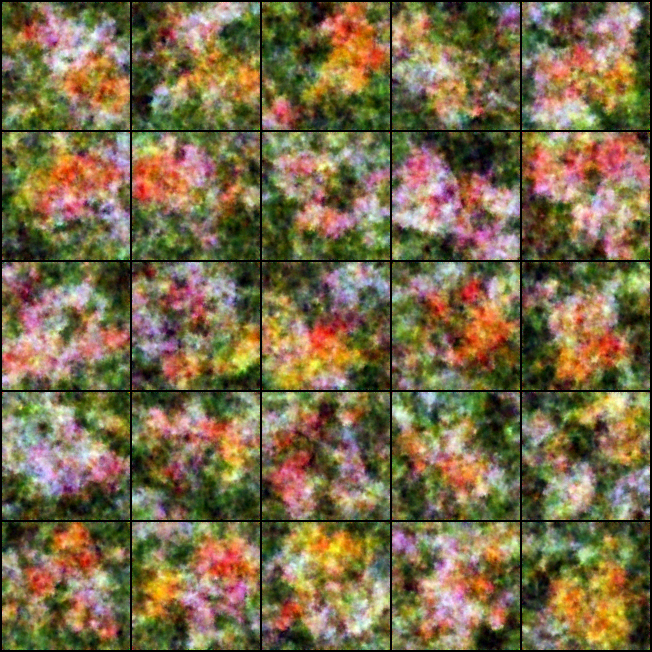

In [ ]:
# 可视化图像看看
from PIL import Image

img = Image.open("./results/sample-1.png")
img